Authors: Yair Andrew Gross & Rafi Kepecs

## Setup

In [2]:
# Enter API account credentials
api_key = 'ob-p-U-gaUnUtxckXt--pKUfcvYeSbZs3CkZ580x6E0grzGkuCdYF0qD9OhItiDQ58j48i7o'

%pip install onboard.client

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from onboard.client import RtemClient
from onboard.client.models import PointSelector

client = RtemClient(api_key=api_key)
# client.whoami()

Note: you may need to restart the kernel to use updated packages.


## Database Exploration

### Contents Overview

The RTEM database contains three main levels. The top level is made up
of **buildings**. Each building can contain multiple pieces of
**equipment**. Each piece of equipment can contain multiple **points**.

A point represents a single sensor, attached to one specific piece of
equipment, within a particular building. Each point, or sensor, records
data over time. The database, via the RTEM API, provides access to that
time series data for each point.

In order to take a closer look at the basic contents of the RTEM API,
we will create dataframes containing all the buildings, equipment, and
points using the API's built in "get_all_[]" methods.

These are quite large, they can be expected to take some time to load.

In [3]:
all_buildings = pd.DataFrame(client.get_all_buildings())
all_equipment = pd.DataFrame(client.get_all_equipment())
all_points = pd.DataFrame(client.get_all_points())

### Basic Statistics

As shown below, there are 229 buildings in the database, with over 6,000
pieces of equipment between them, and a total of nearly 45,000
individual sensors (points).

The statistical distributions of points per piece of equipment and
pieces of equipment per building are also shown below. There is a very
range in both categories, from just one to several hundred. The other
information in the stats table is more revealing, but to understand the
breakdown better we will have to split these up by type in the next
section.

In [4]:
print(f"Buildings: {len(all_buildings.index)}")
print(f"Equipment: {len(all_equipment.index)}")
print(f"Points: {len(all_points.index)}")

Buildings: 229
Equipment: 6085
Points: 44390


In [5]:
# Get stats for pieces of equipment per building
equip_per_bldg_avg = all_equipment.groupby(by='building_id').size().describe()

# Get stats for points per piece of equipment
points_per_equip_avg = all_points.groupby(by='equip_id').size().describe()

# Combine into single dataframe
stats = pd.DataFrame([equip_per_bldg_avg, points_per_equip_avg])
stats = stats.loc[:, stats.columns!='count']
stats.index = ['Equipment Per Building', 'Points Per Equipment']

# Show results
stats

,mean,std,min,25%,50%,75%,max
Equipment Per Building,26.572052,50.564882,1.0,4.0,8.0,25.0,393.0
Points Per Equipment,7.294988,16.952032,1.0,1.0,3.0,10.0,950.0


### Stats By Equipment Type

It make sense that different types of equipment would typically require
different numbers of sensors, so lets break down the equipment by type. 
The following table is a simple count of how many of each type
of equipment there are in the database, as well as statistical
information on the numbers of points per piece of equipment, by type.

In [6]:
# Find the number of points associated with each piece of equipment
points_per_equip = all_points.groupby(by='equip_id',dropna=False)\
    .size().reset_index().rename(columns={0:'count'}).sort_values('equip_id')

# Add number of points as a column to the all_equipment dataframe
all_equipment = all_equipment.sort_values(by='id')
all_equipment['point_count'] = points_per_equip['count']

# Get stats for points per equipment type
equip_type_stats = all_equipment.\
    groupby(['equip_type_name'],dropna=False)\
    ['point_count'].describe().reset_index()

equip_type_stats.head(8)

,equip_type_name,count,mean,std,min,25%,50%,75%,max
0,Air Handling Unit,1165.0,6.332189,13.142179,1.0,1.0,2.0,6.00,292.0
1,Battery,61.0,4.983607,0.288202,4.0,5.0,5.0,5.00,6.0
2,Boiler,140.0,6.957143,11.047882,1.0,1.0,2.5,10.00,75.0
3,Chilled Water Plant,50.0,6.860000,8.727180,1.0,2.0,2.5,10.25,46.0
4,Chiller,151.0,4.973510,6.353946,1.0,1.0,2.0,5.50,34.0
5,Condenser,18.0,9.944444,9.058452,1.0,3.5,11.0,11.00,40.0
6,Cooling Tower,65.0,7.076923,8.045394,1.0,2.0,3.0,10.00,27.0
7,Dry Cooler,1.0,1.000000,NaN,1.0,1.0,1.0,1.00,1.0


Breaking these numbers down slight farther, the next table shows the
number of each equipment _subtype_ in the database, as well as a
statistical summary of the numbers of points per piece of equipment by 
type/subtype.

In [51]:
# Get stats for points per equipment subtype
equip_subtype_stats = all_equipment.\
    groupby(['equip_type_name','equip_subtype_name'],dropna=False)\
    ['point_count'].describe().reset_index()

equip_subtype_stats

,equip_type_name,equip_subtype_name,count,mean,std,min,25%,50%,75%,max
0,Air Handling Unit,Energy Recovery Ventilation Unit,4.0,3.250000,2.061553,1.0,1.75,3.5,5.00,5.0
1,Air Handling Unit,Make Up Air Unit,5.0,2.800000,2.489980,1.0,1.00,1.0,5.00,6.0
2,Air Handling Unit,Roof Top Unit,275.0,5.276364,9.140628,1.0,1.00,2.0,5.00,95.0
3,Air Handling Unit,NaN,881.0,6.695800,14.205812,1.0,1.00,3.0,8.00,292.0
4,Battery,NaN,61.0,4.983607,0.288202,4.0,5.00,5.0,5.00,6.0
5,Boiler,Hot Water Boiler,6.0,2.833333,2.136976,1.0,2.00,2.0,2.75,7.0
6,Boiler,Steam Boiler,4.0,2.500000,1.290994,1.0,1.75,2.5,3.25,4.0
7,Boiler,NaN,130.0,7.284615,11.392391,1.0,1.00,3.0,10.00,75.0
8,Chilled Water Plant,NaN,50.0,6.860000,8.727180,1.0,2.00,2.5,10.25,46.0
9,Chiller,Absorption Chiller,14.0,4.214286,5.950806,1.0,1.00,2.0,3.00,18.0


To visualize the widely varying numbers of points per piece of
equipment, by equipment type. Note that in order to be able to see the
numbers at all, a log scale had to be used for the y-axis.

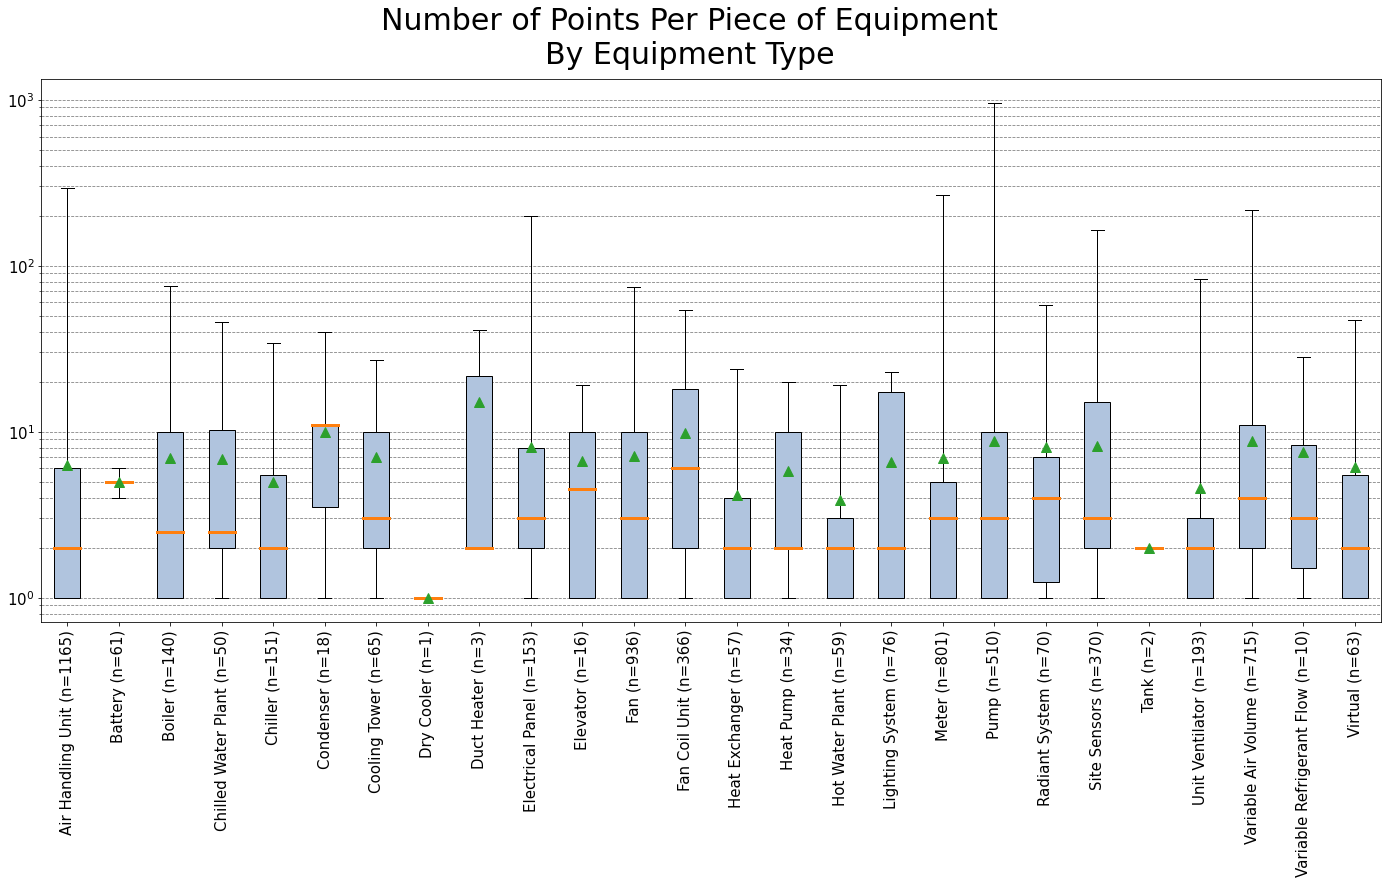

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Change matplotlib default patch color (boxplot fill color)
mpl.rcParams['patch.facecolor'] = 'lightsteelblue'
# Change boxplot default formatting
mpl.rcParams['boxplot.medianprops.linewidth'] = 3.0
mpl.rcParams['boxplot.meanprops.markersize'] = 10

# Format boxplot stats
stats = [
    {
        'mean': float(equip_type_stats.loc[[i],'mean']),
        'med': float(equip_type_stats.loc[[i],'50%']),
        'q1': float(equip_type_stats.loc[[i],'25%']),
        'q3': float(equip_type_stats.loc[[i],'75%']),
        'whislo': float(equip_type_stats.loc[[i],'min']),
        'whishi': float(equip_type_stats.loc[[i],'max'])
    } for i in range(len(equip_type_stats.index))
]

# Create boxplots
fig, ax = plt.subplots(figsize=(24,10))
ax.bxp(stats, showmeans=True,showfliers=False,patch_artist=True);

# Create xtick labels
labels = ["{} (n={})".format(
    equip_type_stats['equip_type_name'][i],
    int(equip_type_stats['count'][i])
) for i in range(len(equip_type_stats.index))]

# Format figure
fig.suptitle("Number of Points Per Piece of Equipment\nBy Equipment Type", fontsize=30)
ax.set_xticklabels(labels, rotation=90, fontsize=15);
ax.set_yscale('log')
ax.grid(axis='y', which='both', color='gray', linestyle='--')
ax.tick_params(axis='y', labelsize=15)

# Save figure
plt.savefig('equip_type_points_boxplot.png', dpi=300, bbox_inches='tight')

### Timeseries Data Selection

We decide to focus our analysis on a single building. To choose a
building we sorted all the buildings by square footage and selected one
that was large, while having a reasonable amount of equipment and
number of points (not too many or too few).The largest building on the
list (id: 439) has just a single piece of equipment with just one point
associated with it. The second largest building (id: 418) has nearly 400
pieces of equipment and nearly 600 points, too many to effectively
analyze. The next three buildings (ids: 140, 65, 48) all lie in between,
with 12 to 38 pieces of equipment, and 42 to 209 points each. We'll take 
a closer look at the equipment and points associated with each building
before deciding which one to analyze more closely.

In [28]:
# Sorting buildings by square footage
all_buildings.sort_values(by='sq_ft', ascending=False)[['id', 'sq_ft', 'equip_count', 'point_count']].head(10)

,id,sq_ft,equip_count,point_count
17,439,3000000.0,1,1
37,418,2800000.0,393,586
140,185,2486000.0,26,209
65,142,2400000.0,12,42
48,98,2338000.0,38,132
164,256,1993000.0,3,30
25,417,1898155.0,45,599
136,194,1700000.0,6,16
33,438,1500000.0,221,1111
113,141,1325000.0,41,82


In [29]:
# Choose buildings to look at more closely
building_ids = [185, 142, 98]

# Count pieces of equipment by type and building
equip_groups = all_equipment.loc[all_equipment['building_id'].isin(building_ids)]\
    .groupby(by=['building_id','equip_type_name']).size().reset_index().rename(columns={0:'equip_count'})

equip_groups

,building_id,equip_type_name,equip_count
0,98,Chilled Water Plant,1
1,98,Chiller,6
2,98,Cooling Tower,10
3,98,Meter,2
4,98,Pump,17
5,98,Site Sensors,1
6,98,Virtual,1
7,142,Air Handling Unit,4
8,142,Chiller,3
9,142,Heat Exchanger,1


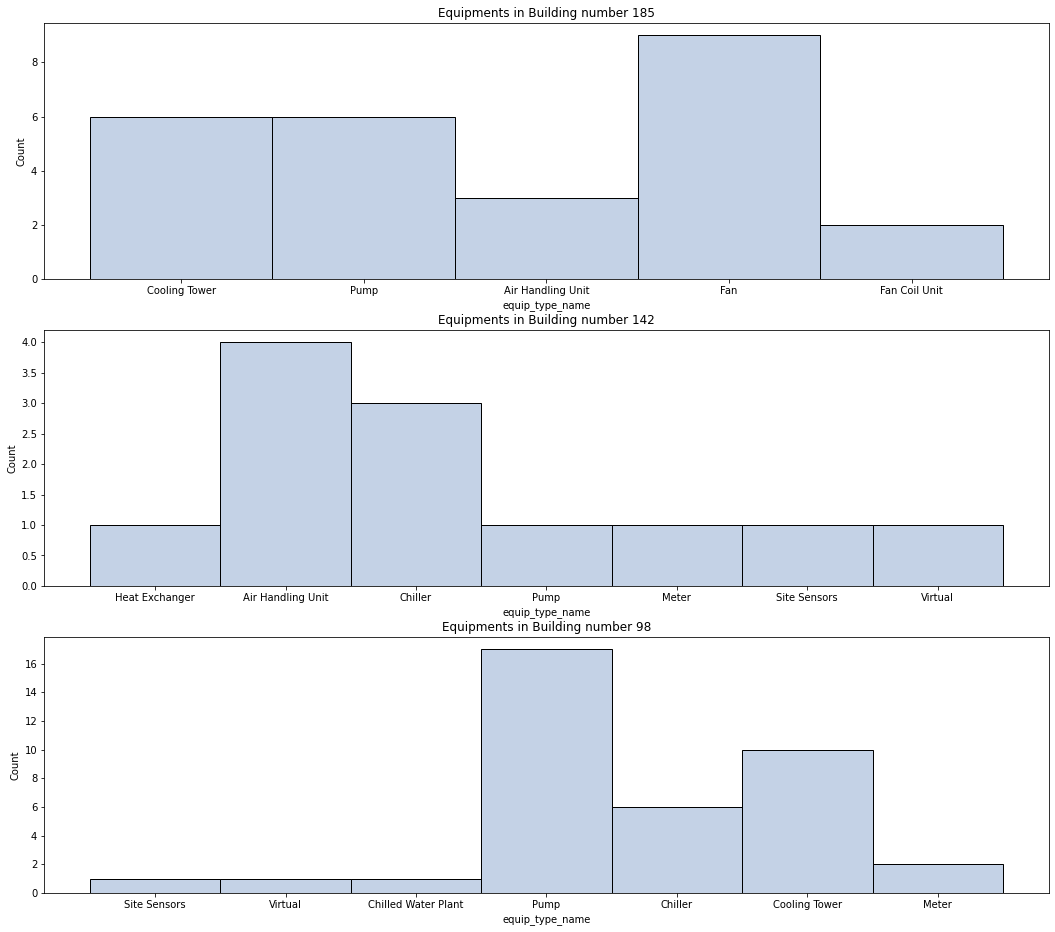

In [35]:
fig, axes = plt.subplots(len(building_ids), 1, figsize=(18, 16))


for i in range(len(building_ids)):
    id = building_ids[i]
    building_equipment = pd.DataFrame(client.get_building_equipment(id))

    sns.histplot(ax = axes[i], data=building_equipment, x="equip_type_name", binwidth=3)
    axes[i].set_title(f"Equipments in Building number {id}");

In [48]:
query = PointSelector()
query.buildings = building_ids[0:1]

result = client.select_points(query)

result_points = pd.DataFrame(client.get_points_by_ids(result['points']))
result_points

,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
0,310008,441,1.560485e+12,1.550504e+12,None,None,None,225 E 149th St. Boiler-1 Air Temp,None,?,?,23,48.22,Virtual,434,18,4bfeb1918fb9434f2cf3f0ea464619f2,nyserda+0000088737+boiler-1+225 E 149th St. Bo...,None,28797
1,310009,441,1.560485e+12,1.550701e+12,None,None,None,225 E 149th St. Boiler-1 Exhaust Temp,None,F,f,2,183.55,Exhaust Air Temperature,86,1,4a1a11502acee3078352da312c40c262,nyserda+0000088737+boiler-1+225 E 149th St. Bo...,None,28797
2,310010,441,1.560571e+12,1.550504e+12,None,None,None,225 E 149th St. Boiler-1 Fault Code,None,?,?,23,0,Virtual,434,18,55882633fe8fb5aac7dac643c99b1af5,nyserda+0000088737+boiler-1+225 E 149th St. Bo...,None,28797
3,310011,441,1.560485e+12,1.550504e+12,None,None,None,225 E 149th St. Boiler-1 FFWD Temp,None,?,?,23,46.90,Virtual,434,18,831a8df09b848f53e807fa0204c45eaa,nyserda+0000088737+boiler-1+225 E 149th St. Bo...,None,28797
4,310012,441,1.560485e+12,1.550504e+12,None,None,None,225 E 149th St. Boiler-1 Fire Rate In,None,?,?,23,91,Virtual,434,18,aa147c829c7ed55b6e93cdbbb8b43d55,nyserda+0000088737+boiler-1+225 E 149th St. Bo...,None,28797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,311291,441,1.609476e+12,1.561954e+12,None,None,None,245 E 149th St. Roof Boiler Plant Sensor Statu...,None,?,?,23,1,Virtual,434,18,fe1253c77d6b51482a9b794c7f3becd4,nyserda+0000088737+virtual+245 E 149th St. Roo...,None,28814
1289,311292,441,1.609476e+12,1.547401e+12,None,None,None,245 E 149th St. System Cool Enabled,None,?,?,23,AAAA,Virtual,434,18,9f1469b7ce27d05790217d3c1f58b867,nyserda+0000088737+virtual+245 E 149th St. Sys...,None,28814
1290,311293,441,1.609476e+12,1.547401e+12,None,None,None,245 E 149th St. System Heat Enabled,None,?,?,23,AAAB,Virtual,434,18,8e366de75b3685414129a98e4f83f872,nyserda+0000088737+virtual+245 E 149th St. Sys...,None,28814
1291,311294,441,1.560571e+12,1.554785e+12,None,None,None,245 E 149th St. Water Meter Code,None,?,?,23,16,Virtual,434,18,439181c6891b5b7fa7a472e64fcf4949,nyserda+0000088737+virtual+245 E 149th St. Wat...,None,28814
